#Transfer Learning Part-1: Feature Extraction

In [1]:
!nvidia-smi

Fri Jul 30 21:11:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2021-07-30 21:12:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 142.250.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   183MB/s    in 0.9s    

2021-07-30 21:12:04 (183 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
import os

for dirpath,dirnames,filenames in os.walk('10_food_classes_10_percent'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [8]:
#preping the data

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                           target_size=IMAGE_SHAPE,
                                                           batch_size=BATCH_SIZE,
                                                           class_mode='categorical')

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [10]:
#Callback(functionize)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name +'/'+experiment_name+datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [11]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# EfficientNet0 feature vector
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [12]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [19]:
#create_model function

def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """ 
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name='feature_extractor_layer',
                                           input_shape=IMAGE_SHAPE+(3,))

  model = tf.keras.Sequential([
                               feature_extractor_layer,
                               layers.Dense(num_classes, activation='softmax',name='output_layer')
  ])

  return model
  

In [20]:
#create resnet tfhub feature extration model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [21]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor_layer (Ker (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [22]:
#compile model

resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [24]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                         experiment_name='resnet50V2')])

Saving TensorBoard log files to: tensorflow_hub/resnet50V220210730-222017
Epoch 1/5
24/24 [==============================] - 52s 818ms/step - loss: 1.7762 - accuracy: 0.4080 - val_loss: 1.1535 - val_accuracy: 0.6388
Epoch 2/5
24/24 [==============================] - 16s 672ms/step - loss: 0.8619 - accuracy: 0.7533 - val_loss: 0.8441 - val_accuracy: 0.7196
Epoch 3/5
24/24 [==============================] - 16s 691ms/step - loss: 0.5992 - accuracy: 0.8133 - val_loss: 0.7443 - val_accuracy: 0.7592
Epoch 4/5
24/24 [==============================] - 16s 701ms/step - loss: 0.4576 - accuracy: 0.8853 - val_loss: 0.7186 - val_accuracy: 0.7600
Epoch 5/5
24/24 [==============================] - 16s 668ms/step - loss: 0.3653 - accuracy: 0.9173 - val_loss: 0.6906 - val_accuracy: 0.7744


Wow!!.90% on training and 70% on validation 😱 with only 20% of the dataset.

Power of transfer Learning(feature extractor)

In [28]:
#plot our loss curves'

import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

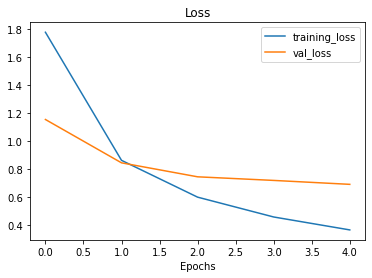

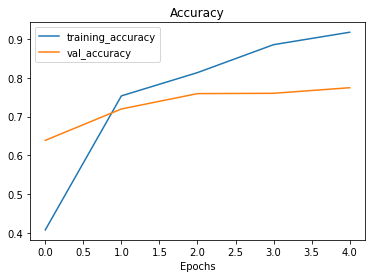

In [38]:
plot_loss_curves(resnet_history)

EfficientNetB0

In [39]:
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])


efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                     experiment_name='effecientNetB0')])

Saving TensorBoard log files to: tensorflow_hub/effecientNetB020210730-231153
Epoch 1/5
24/24 [==============================] - 26s 790ms/step - loss: 1.8542 - accuracy: 0.4507 - val_loss: 1.2828 - val_accuracy: 0.7256
Epoch 2/5
24/24 [==============================] - 16s 675ms/step - loss: 1.0717 - accuracy: 0.7840 - val_loss: 0.8567 - val_accuracy: 0.8204
Epoch 3/5
24/24 [==============================] - 15s 645ms/step - loss: 0.7671 - accuracy: 0.8333 - val_loss: 0.6909 - val_accuracy: 0.8460
Epoch 4/5
24/24 [==============================] - 15s 638ms/step - loss: 0.6156 - accuracy: 0.8653 - val_loss: 0.6042 - val_accuracy: 0.8584
Epoch 5/5
24/24 [==============================] - 15s 649ms/step - loss: 0.5180 - accuracy: 0.8907 - val_loss: 0.5522 - val_accuracy: 0.8584


Impressive stats again

In [40]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor_layer (Ker (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


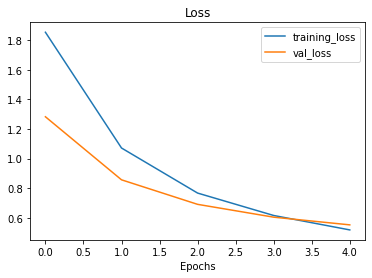

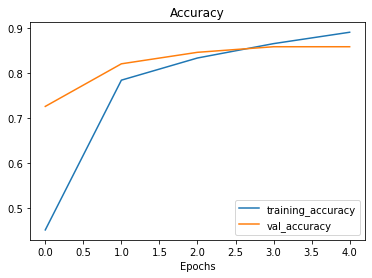

In [41]:
plot_loss_curves(efficientnet_history)

In [42]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor_layer (Ker (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [43]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor_layer (Ker (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
#Conparing results with TensorBoard

!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

[Public Link](https://tensorboard.dev/experiment/pt7k0lKjRdO0jdwJC9DYfQ/)

In [47]:
!tensorboard dev list

2021-07-30 23:42:49.101277: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/pt7k0lKjRdO0jdwJC9DYfQ/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   pt7k0lKjRdO0jdwJC9DYfQ
	Created              2021-07-30 23:38:37 (4 minutes ago)
	Updated              2021-07-30 23:38:42 (4 minutes ago)
	Runs                 8
	Tags                 5
	Scalars              120
	Tensor bytes         0
	Binary object bytes  14452873
Total: 1 experiment(s)


In [ ]:
# Delete the exp.
# !tensorboard dev delete --experiment_id pt7k0lKjRdO0jdwJC9DYfQ


----
----